Problem Set 7 Problem 2: A* search on Euclidean spaces
========================

In this problem, we’re going to examine the results of using A∗ with
different potential functions.


In [1]:
# You may need to `pip install networkx` and `pip install numpy`
# We'll use NetworkX again.
import networkx as nx
# https://networkx.github.io/documentation/stable/tutorial.html

import numpy
import heapq

#Visualization tools
import pylab
import matplotlib
%matplotlib inline

In [2]:
# Somehow, this setting gets overridden if it's placed in the previous code block.
# If someone can explain this curious behavior to me, I'd appreciate it. =)

matplotlib.rcParams['figure.figsize'] = (10,10)

# Graph generation and visualization

In [3]:

def generate_graph(n, d):
    """Generate a random Euclidean graph.
    
    n points are placed uniformly on [-1, 1]^2 and bidirectionally
    connected to the nearest d other points.  The distance is the
    Euclidean distance between the points.
    """
    
    # Compute the positions of the n points
    locs = numpy.random.rand(n, 2)
    # Compute the pairwise difference vectors (for an n x n x 2 matrix)
    gaps = locs.reshape(n, 1, 2) - locs.reshape(1, n, 2)
    # Compute the pairwise differences
    distances = numpy.linalg.norm(gaps, axis=2)
    nearest = numpy.argpartition(distances, d)[:,:d]

    # Now make a NetworkX graph
    G = nx.DiGraph()
    for i, (x,y) in enumerate(locs):
        G.add_node(i, point=(x, y))
    for i, lst in enumerate(nearest):
        for j in lst:
            G.add_edge(i, j, weight=distances[i][j])
            if i not in nearest[j]: # Make sure it's symmetric
                G.add_edge(j, i, weight=distances[i][j])
    return G

In [4]:
def draw_graph(G, **kws):
    default_kws = dict(node_size=3.5, linewidths=0, width=0.05,
                       with_labels=False, alpha=1, arrows=False)
    default_kws.update(kws)
    nx.draw_networkx(G, {k:v['point'] for k,v in G.nodes.items()},
                     **default_kws)
    pylab.xlim([0,1])
    pylab.ylim([0,1])

In [5]:
# Example (this can take some time)
G = generate_graph(10, 4)

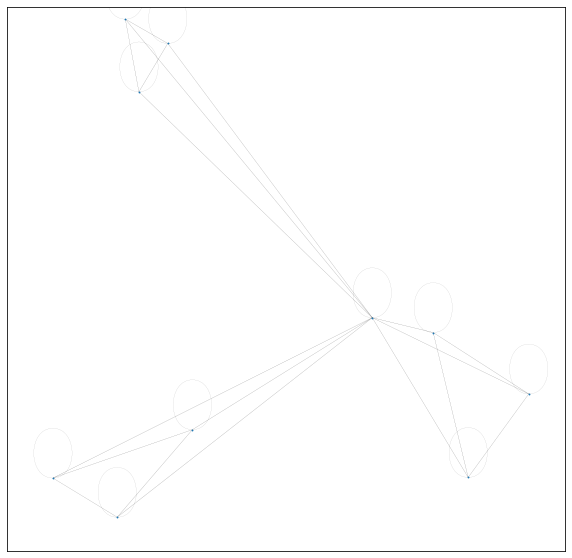

In [6]:
# If you get a MatplotlibDeprecationWarning here, you should ignore it
draw_graph(G)

# Shortest path computation

In [7]:
def dijkstra(G, s, t, potential = lambda u: 0):
    """Find the shortest path from s to t using Dijkstra/A*.

    Given:
      - s, the node to start from
      - t, the node to finish at (or None)
      - potential, a function from node id to R.

    Returns a tuple containing:
       - path, a list containing nodes along the shortest path from s to t.
       - prev, a dict giving back pointers on the shortest path
         tree starting at s.  prev[v] is correct for all v in visited.
       - dists, a dict giving the distance to nodes.  This should be
         correct for visited nodes.
       - count, the number of iterations the algorithm takes (purely for performance testing)

    If t is None, it returns the full shortest path tree from s, and
    'path' is None.
    """
    count = 0
    dists = {}
    prev = {}
    heap = []
    heapq.heappush(heap, (0 + potential(s), s, None))
    while heap and t not in prev:
        d, u, parent = heapq.heappop(heap)
        d -= potential(u)
        if u in dists and dists[u] <= d:
            continue
        count += 1
        dists[u] = d
        prev[u] = parent
        for v in G[u]:
            length = G[u][v]['weight']
            heapq.heappush(heap, (dists[u] + length + potential(v), v, u))
    # Now find the path, if we have a destination.
    if t is None:
        path = None
    else: # Find the s-t path.
        if t not in prev:
            print('Warning: no path from s to t')
            path = []
        else:
            v = t
            path = [v]
            while v != s:
                v = prev[v]
                path.append(v)
            path.reverse()
    return (path, prev, dists, count)

In [8]:
# We need to be able to visualize the result
def visualize_path(G, s, t, path, prev, dists=None, count=None, **kws):
    print(f'Got s-t distance {dists.get(t)} visiting {len(dists)} nodes',
         f'(in {count} iterations)' if count != len(dists) else '')
    # Full graph
    draw_graph(G, width=0.03)
    # Visited nodes
    draw_graph(G,  width=0, nodelist=dists.keys(),
               edgelist=[e for e in G.edges() if e[0] in dists], 
               node_size=4, node_color='green')
    # Computed shortest path tree
    draw_graph(G,  width=0.3, nodelist=[],
               edgelist=[e for e in G.edges() if prev.get(e[1]) == e[0] ], 
               node_size=4, node_color='green')
    # Computed shortest s-t path tree
    if path:
        pathset = set(path)
        draw_graph(G,  width=1, nodelist=[],
                   edgelist=[e for e in G.edges() if prev.get(e[1]) == e[0] 
                            and e[1] in pathset], 
                   node_size=4, node_color='green')
    # s and t
    draw_graph(G, nodelist=[s], edgelist=[],
               node_size=40, node_color='purple')
    if t is not None:
        draw_graph(G, nodelist=[t], edgelist=[],
                   node_size=40, node_color='blue')


Got s-t distance 0.29287413120872086 visiting 6 nodes 


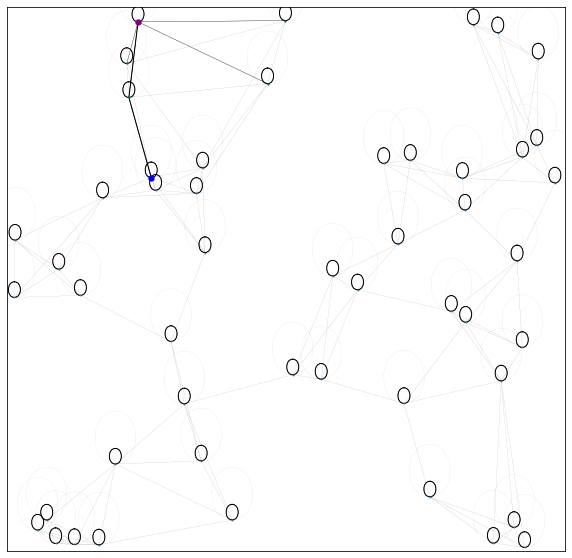

In [9]:
# Example usage
# purple dot = source, blue dot = sink, green = visited, red = unvisited
# Thickest lines = shortest s-t path
# medium thick lines = edges on shortest path tree

G = generate_graph(50, 5)
s, t = 0, 1
visualize_path(G, s, t, *dijkstra(G, s, t))

# Run this several times to see how it behaves.

In [10]:
#Now let's try a couple heuristics

def euclidean(a, b):
    """Return the Euclidean (ell_2) distance between two vectors."""
    return sum((x - y)**2 for x, y in zip(a, b))**.5

def manhattan(a, b):
    """Return the Manhattan (ell_1) distance between two vectors."""
    return sum(abs(x - y) for x, y in zip(a, b))

Got s-t distance 0.66621440265124 visiting 69 nodes 
Got s-t distance 0.6662144026512402 visiting 10 nodes 
Got s-t distance 0.7070457907625796 visiting 13 nodes 
Got s-t distance 0.6662144026512402 visiting 25 nodes 


Text(0.5, 1.0, 'Manhattan, scaled by 1/sqrt(2)')

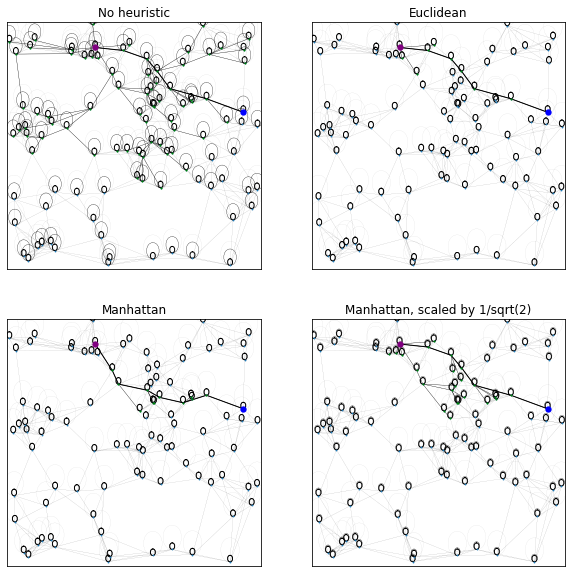

In [11]:
G = generate_graph(100, 6)
s, t = 0, 1
pylab.subplot(2,2,1)
visualize_path(G, s, t, *dijkstra(G, s, t))
pylab.title("No heuristic")
pylab.subplot(2,2,2)
visualize_path(G, s, t, *dijkstra(G, s, t,
        lambda u: euclidean(G.nodes[u]['point'], G.nodes[t]['point'])))
pylab.title("Euclidean")
pylab.subplot(2,2,3)
visualize_path(G, s, t, *dijkstra(G, s, t,
        lambda u: manhattan(G.nodes[u]['point'], G.nodes[t]['point'])))
pylab.title("Manhattan")

pylab.subplot(2,2,4)
visualize_path(G, s, t, *dijkstra(G, s, t,
        lambda u: manhattan(G.nodes[u]['point'], G.nodes[t]['point'])/2**.5))
pylab.title("Manhattan, scaled by 1/sqrt(2)")

#Run this a few times.

Problem (a)
----------

When you run the above code, sometimes one of the distances will not match the other two.  Why is that?

The ALT heuristic
==========

We now consider the ALT heuristic.  The ALT stands
for "A^∗, landmarks, and triangle inequality". It’s a way of preprocessing the graph to construct a potential function such that
fresh queries--new s and t pairs--can be solved very efficiently.

This is useful for something like Google Maps, where they get many many queries on the same graph, and need to respond very quickly to each one.  So it makes sense to spend some preprocessing time beforehand to make the queries fast.

The idea behind ALT is to choose a small number of nodes `l_1, ..., l_L` to be "landmarks" (say, 10-20). We preprocess the graph using full Dijkstra
to compute `dist(u, l_i)` for all vertices `u` and landmarks `l_i`.
On a new query s, t, we observe by the triangle inequality that
```
dist(u, t) ≥ dist(u, l) − dist(t, l)
```
and
```
dist(u, t) ≥ dist(l, t) − dist(l, u)
```
for all landmarks `l`. Hence, if we set
```
potential(u) := max_l |dist(u, l) − dist(t, l)|
```
we get an "admissible" heuristic (i.e., `potential(u) ≤ d(u, t)` for all `u`).  Admissibility means that our implementation of Dijkstra returns the correct answer (but possibly in exponential time, from revisiting vertices if it finds a new path of shorter length).  That is, when we visit the target node `t`, we are guaranteed to have found the shortest path.

But to make it fast, we want a "consistent" heuristic, so that the reweighted distance function is nonnegative and we do not revisit nodes.  (Hence when we visit any node `v`, we are guaranteed to have found the shortest path there.)

 Problem (b)
 -------
Show that the ALT potential function is in fact consistent.  I.e., 
```
potential(u) - potential(v) <= dist(u, v)
```
 for all `u, v`.

graph generated
landmarks and heuristic function generated
s,t are assigned as 0 1 respectively
heuristic determined
Got s-t distance 0.9324012787739856 visiting 18 nodes 
Got s-t distance 0.9324012787739856 visiting 62 nodes 
0 1


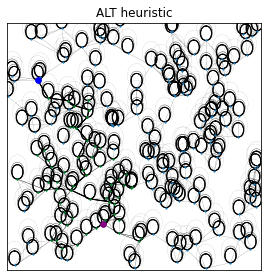

In [16]:
# Problem (c)  Implement the ALT heuristic.

# With 20 landmarks, it should usually visit less than 1/3 as many
# nodes as the Euclidean heuristic. (You can either choose random
# landmarks or try to pick them more carefully.)

def create_landmark_heuristic_generator(G):
    """Preprocess the graph so that one can compute a heuristic
    for any desired destination t.
    
    Returns a function that takes t and returns a heuristic
    targetted at t.
    """
    # Construct landmarks and distances to/from landmarks
    # do preprocessing
    n = len(G.nodes)
    lx = [numpy.random.randint(0,n) for i in range(0,20)] 
    all_dists = {}

    for u in G.nodes:
        for l in lx:
            p = dijkstra(G, u, l)
            if p[0] != []: 
                all_dists[(u,l)] = dijkstra(G, u, l)[2][l]
            
    def construct_heuristic_for(t):
        def heuristic(u):
            pot_list = [0 for x in range(0,20)] 
            for i in range(len(pot_list)):
                pot_list[i] = abs(all_dists.get((u,lx[i])) - all_dists.get((t,lx[i])))
            return max(pot_list)
        return heuristic
    return construct_heuristic_for

G = generate_graph(200, 4)
print("graph generated")
# Now you should be able to plot it with something like this.
pylab.subplot(2,2,4)
pylab.title("ALT heuristic")
heuristic_generator = create_landmark_heuristic_generator(G)
print("landmarks and heuristic function generated")
t = numpy.random.choice(G.nodes)
s = 0;
print(*['s,t are assigned as', s, t, 'respectively'])
heuristic_for_t = heuristic_generator(t)
print("heuristic determined")
visualize_path(G, s, t, *dijkstra(G, s, t, heuristic_for_t))
visualize_path(G, s, t, *dijkstra(G, s, t,
        lambda u: euclidean(G.nodes[u]['point'], G.nodes[t]['point'])))
print(s, t)

# Try to make sure it's plotted on the same graph as the other
# heuristics above.  How does the number of visited nodes
# compare?